In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Cell 1 — Imports, paths, and template setup

import os, json, math
from typing import List

import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display

import torch
from transformers import AutoProcessor, AutoModelForVision2Seq
# import open_clip

from google.colab import files

PROJ       = "/content/drive/MyDrive/VQAScore_Project"
DATA_DIR   = f"{PROJ}/data"
RESULTS_DIR= f"{PROJ}/results"
TEMPLATES  = f"{DATA_DIR}/templates.json"

device = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.float16 if device == "cuda" else torch.float32

print("Project:", PROJ)
print("Device :", device)

# Load templates (baseline + extras)
if os.path.exists(TEMPLATES):
    tmpl_cfg = json.load(open(TEMPLATES))
    templates_list = tmpl_cfg.get("templates", [])
else:
    templates_list = []

# Ensure we have a nice basic set
default_templates = [
    'Does this figure show "{}"? Please answer yes or no.',
    'Is there "{}" in this image? Please answer yes or no.',
    'Does the photo depict "{}"? Please answer yes or no.',
    'Is this picture about "{}"? Please answer yes or no.'
]
templates_list = list(dict.fromkeys(templates_list + default_templates))

print("Available question templates:")
for i, t in enumerate(templates_list):
    print(f"[{i}] {t}")


Project: /content/drive/MyDrive/VQAScore_Project
Device : cpu
Available question templates:
[0] Does this figure show "{}"? Please answer yes or no.
[1] Is there "{}" in this image? Please answer yes or no.
[2] Does the photo depict "{}"? Please answer yes or no.
[3] Is this picture about "{}"? Please answer yes or no.


In [5]:
%pip install --quiet open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00


In [ ]:
# Cell 2 — Load models (same configuration as your improved Phase 3)
import open_clip
# VQA model (InstructBLIP Vicuna 7B)
VQA_MODEL_ID = "Salesforce/instructblip-flan-t5-xl"
vqa_processor = AutoProcessor.from_pretrained(VQA_MODEL_ID)
vqa_model = AutoModelForVision2Seq.from_pretrained(
    VQA_MODEL_ID,
    torch_dtype=DTYPE
).to(device).eval()

print("Loaded VQA model:", VQA_MODEL_ID, "on", device)

# CLIP model (ViT-L/14) — upgraded from B/32
clip_model_name = "ViT-B-32"
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms(
    clip_model_name,
    pretrained="openai"
)
clip_model = clip_model.to(device).eval()
clip_tokenizer = open_clip.get_tokenizer(clip_model_name)

print("Loaded CLIP model:", clip_model_name, "on", device)


In [8]:
# Should be same as in phase 3 notebook
@torch.inference_mode()
def vqa_yes_probability(image: Image.Image, prompt: str, template: str) -> float:
    """
    Approximate P(Yes | image, question) by comparing NLL of 'Yes' and 'No'
    answers and normalizing:
        p_yes = exp(-L_yes) / (exp(-L_yes) + exp(-L_no))
    This keeps scores in [0, 1] and makes them easier to interpret/compare.
    """
    question = template.format(prompt)

    # Encode the (image, question) once
    inputs = vqa_processor(images=image, text=question, return_tensors="pt").to(device)

    # Prepare target token ids for "Yes" and "No"
    yes_ids = vqa_processor.tokenizer("Yes", return_tensors="pt").input_ids.to(device)
    no_ids  = vqa_processor.tokenizer("No",  return_tensors="pt").input_ids.to(device)

    # Compute loss for each possible answer
    out_yes = vqa_model(**inputs, labels=yes_ids)
    out_no  = vqa_model(**inputs, labels=no_ids)

    nll_yes = float(out_yes.loss.item())
    nll_no  = float(out_no.loss.item())

    # Convert negative NLLs into normalized probabilities
    p_yes = math.exp(-nll_yes)
    p_no  = math.exp(-nll_no)
    denom = p_yes + p_no if (p_yes + p_no) > 0 else 1e-8

    return p_yes / denom

In [9]:
# Cell 4 — CLIPScore helper with ViT-L/14

@torch.inference_mode()
def clip_score(image: Image.Image, prompt: str) -> float:
    """
    Compute cosine similarity between CLIP image and text embeddings.
    Returns a scalar in roughly [0, 1]-ish range (cosine similarity).
    """
    img_tensor = clip_preprocess(image).unsqueeze(0).to(device)
    txt_tokens = clip_tokenizer([prompt]).to(device)

    image_features = clip_model.encode_image(img_tensor)
    text_features  = clip_model.encode_text(txt_tokens)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features  /= text_features.norm(dim=-1, keepdim=True)

    sim = (image_features @ text_features.T).item()
    return float(sim)

In [12]:
# Cell 5 — Single evaluation helper: given image path + prompt + template index

def evaluate_image_prompt(image_path: str, prompt: str, template_idx: int = 0):
    assert os.path.exists(image_path), f"Image path not found: {image_path}"

    # Clamp template index
    if template_idx < 0 or template_idx >= len(templates_list):
        template_idx = 0

    template = templates_list[template_idx]
    template.format(prompt)
    image = Image.open(image_path).convert("RGB")

    print("=== Evaluation ===")
    print("Image path :", image_path)
    print("Prompt     :", prompt)
    print("Template   :", template)
    display(image)

    vqa = vqa_yes_probability(image, prompt, template)
    cs  = clip_score(image, prompt)

    print("\nScores:")
    print(f"- VQAScore (P(Yes)) : {vqa:.3f}")
    print(f"- CLIPScore         : {cs:.3f}")

    return {
        "image_path": image_path,
        "prompt": prompt,
        "template": template,
        "VQAScore": vqa,
        "CLIPScore": cs,
    }

In [11]:
# Cell 6 — Mode 1: Upload an image from your local machine

def upload_image() -> str:
    """
    Opens a file picker in Colab and uploads an image.
    Returns the local temp filename in /content.
    """
    print("Choose an image file to upload...")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded.")
        return None

    fname = list(uploaded.keys())[0]
    print("Uploaded:", fname)
    return fname

print("You can now run the next cell to upload an image and evaluate it.")

You can now run the next cell to upload an image and evaluate it.


Choose an image file to upload...


Saving istockphoto-833503586-170667a.jpg to istockphoto-833503586-170667a.jpg
Uploaded: istockphoto-833503586-170667a.jpg
=== Evaluation ===
Image path : istockphoto-833503586-170667a.jpg
Prompt     : a cat wearing sunglasses
Template   : Does this figure show "{}"? Please answer yes or no.


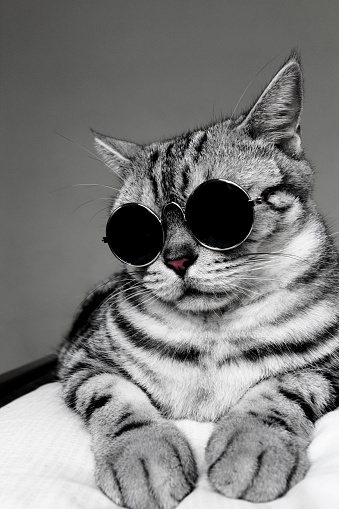


Scores:
- VQAScore (P(Yes)) : 0.756
- CLIPScore         : 0.330


In [13]:
# Cell 7 — Interactive-ish demo: upload image, type prompt, pick template index

# 1) Upload image
img_path = upload_image()  # run this cell, pick an image file

# 2) Manually set your prompt and template index here
prompt = "a cat wearing sunglasses"
template_idx = 0

if img_path is not None:
    result = evaluate_image_prompt(img_path, prompt, template_idx)
else:
    print("No image to evaluate.")


In [14]:
# Cell 9 — Optional: save last demo result to a small JSON log for reference

import time

def save_demo_result(result: dict):
    os.makedirs(RESULTS_DIR, exist_ok=True)
    ts = int(time.time())
    out_path = os.path.join(RESULTS_DIR, f"demo_eval_{ts}.json")
    with open(out_path, "w") as f:
        json.dump(result, f, indent=2)
    print("Saved demo result to:", out_path)

# If you just ran an evaluation and have `result` in scope:
try:
    _ = result
    save_demo_result(result)
except NameError:
    print("No `result` in scope yet. Run an evaluation cell first.")

Saved demo result to: /content/drive/MyDrive/VQAScore_Project/results/demo_eval_1764179834.json
